### imports

In [192]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.transforms import RandomNodeSplit
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import Planetoid, CoraFull
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

### Utils

#### plot function

In [193]:
def plot_accuracies_losses(train_accuracies, val_accuracies, train_losses, val_losses):

    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### Test functions

In [367]:
def run_test_(method, dataset, arguments=None, p=True, pf=True):
    if arguments == None:
        raise Exception("No arguments given!")
 
    dataset.to(torch.device("cpu"))

    method_name = method.__name__
    if method_name == "MLP":
        dataset_train, dataset_val, dataset_test = arguments['change_dataset'](dataset, batch_size=arguments['batch_size'])
        model = method(
                    input_size=dataset.num_node_features,
                    output_size=len(np.bincount(dataset.y)),
                    hidden_size=arguments['hidden_size'],
                    n_layers=arguments['n_layers'],
                    lr=arguments['lr'],
                    dropout_p=arguments['dropout_p']
                )
        train_accuracies, val_accuracies, train_losses, val_losses = model.train_function(dataset_train, dataset_val, num_epochs=arguments['num_epochs'], p=p)
        test_accuracy, test_loss = model.evaluate_function(dataset_test)

        if pf:
            train_accuracy, train_loss = model.evaluate_function(dataset_train)
            print(f"\n\tOn Train set:\n\tFinal Accuracy: {train_accuracy:.2f}%, Final Loss: {train_loss:.4f}")
            val_accuracy, val_loss = model.evaluate_function(dataset_val)
            print(f"\n\tOn Validation set\n\tFinal Accuracy: {val_accuracy:.2f}%, Final Loss: {val_loss:.4f}")
            print(f"\n\tOn Test set\n\tFinal Accuracy: {test_accuracy:.2f}%, Final Loss: {test_loss:.4f}")
            
            plot_accuracies_losses(train_accuracies, val_accuracies, train_losses, val_losses)
    
    else:
        if method_name == 'GCN' or method_name == 'SkipConnectionGCN' or method_name == 'DSGNN':
            model = method(
                input_dim=dataset.num_node_features,
                output_dim=len(np.bincount(dataset.y)),
                hidden_dim=arguments['hidden_dim'],
                n_layers=arguments['n_layers'],
                lr=arguments['lr'],
                dropout_p=arguments['dropout_p'],
                weight_decay=arguments['weight_decay']
            )

        elif method_name == 'GAT' or method_name == 'GATv2':
            model = method(
                input_dim=dataset.num_node_features,
                output_dim=len(np.bincount(dataset.y)),
                hidden_dim=arguments['hidden_dim'],
                n_layers=arguments['n_layers'],
                lr=arguments['lr'],
                dropout_p=arguments['dropout_p'],
                n_heads=arguments['n_heads'],
                weight_decay=arguments['weight_decay']
            )

        elif method_name == 'DropEdgeGCN':
            model = method(
                input_dim=dataset.num_node_features,
                output_dim=len(np.bincount(dataset.y)),
                hidden_dim=arguments['hidden_dim'],
                n_layers=arguments['n_layers'],
                lr=arguments['lr'],
                dropout_p=arguments['dropout_p'],
                dropedge_p=arguments['dropedge_p'], # dropedge probability
                weight_decay=arguments['weight_decay'],
                layer_wise=arguments['layer_wise']
            )

        else:
            raise Exception("Wrong Method Selected!")

        train_accuracies, val_accuracies, train_losses, val_losses = model.train_function(dataset, dataset.train_mask, dataset.val_mask, num_epochs=arguments['num_epochs'], p=p)
        test_accuracy, test_loss = model.evaluate_function(dataset, dataset.test_mask)

        if pf:
            train_accuracy, train_loss = model.evaluate_function(dataset, dataset.train_mask)
            print(f"\n\tOn Train set:\n\tFinal Accuracy: {train_accuracy:.2f}%, Final Loss: {train_loss:.4f}")
            val_accuracy, val_loss = model.evaluate_function(dataset, dataset.val_mask)
            print(f"\n\tOn Validation set\n\tFinal Accuracy: {val_accuracy:.2f}%, Final Loss: {val_loss:.4f}")
            print(f"\n\tOn Test set\n\tFinal Accuracy: {test_accuracy:.2f}%, Final Loss: {test_loss:.4f}")
            
            plot_accuracies_losses(train_accuracies, val_accuracies, train_losses, val_losses)

    return test_accuracy, test_loss

In [195]:
def run_multitest_(method, dataset, n_tests=10, arguments=None, p=True):
    if arguments == None:
        raise Exception("No arguments given!")

    accs = 0.0
    losses = 0.0
    for i in range(n_tests):
        acc, loss = run_test_(method=method, dataset=dataset, arguments=arguments, p=False, pf=False)
        accs += acc
        losses += loss
        if p:
            print(f"Test {i+1:2d} Accuracy: {acc:.2f}%, Loss: {loss:.4f}")

    accs /= n_tests
    losses /= n_tests
    if p:
        print(f"\n\tFinal Mean Test Accuracy: {accs:.2f}%, Final Mean Test Loss: {losses:.4f}")

    return accs, losses

In [230]:
def reset_my_seed(seed=10):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## 1st Question

### A) Dataset

#### dataset utils

In [196]:
def report_dataset(dataset, name):
    classes = np.bincount(dataset.y)

    print(f"Dataset: {name}")
    print(f"Number of nodes: {dataset.num_nodes}")
    print(f"Number of edges: {dataset.num_edges}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {len(classes)}\n{classes}\n")
    
def split_dataset(dataset, num_val=0.1, num_test=0.2):
    split = RandomNodeSplit(num_val=num_val, num_test=num_test)
    dataset = split(dataset)

    print(f'Train size: {dataset.train_mask.sum()}')
    print(f'Validation size: {dataset.val_mask.sum()}')
    print(f'Test size: {dataset.test_mask.sum()}\n')

    return dataset


#### CiteSeer

In [206]:
dataset_citeseer = Planetoid(root='data/CiteSeer', name='CiteSeer')[0]

report_dataset(dataset_citeseer, "CiteSeer")

dataset_citeseer = split_dataset(dataset_citeseer)

Dataset: CiteSeer
Number of nodes: 3327
Number of edges: 9104
Number of features: 3703
Number of classes: 6
[264 590 668 701 596 508]

Train size: 2329
Validation size: 333
Test size: 665



#### CoraFull

In [202]:
dataset_corafull = CoraFull(root='data/CoraFull')[0]

report_dataset(dataset_corafull, "CoraFull")

dataset_corafull = split_dataset(dataset_corafull)

Dataset: CoraFull
Number of nodes: 19793
Number of edges: 126842
Number of features: 8710
Number of classes: 70
[257  52 243 378  63 305 404 663 240 342 141 223 102 521 341 138 115 111
  80 435 420 254 414 196 334 315 284 783 113 466 221 376 154 855 576  84
 293 163 125 564 280 205  94  53 129 370 122  74 557 285  72 625 501 650
  99 473 324 928 212 301 116 220 165 291 147  91 137  84  15  29]

Train size: 13855
Validation size: 1979
Test size: 3959



### B) MLP classifier

#### Network MLP

In [207]:
class MLP(nn.Module):
    def __init__(
                self,
                input_size,
                output_size,
                n_layers=3,
                hidden_size=512,
                lr=0.001,
                dropout_p=0.5
            ):
        super(MLP, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers
        self.input_size = input_size
        self.output_size = output_size

        if self.n_layers == 1:
            self.fc_out = nn.Linear(self.input_size, self.output_size)
        else:
            self.hidden_size = hidden_size
            self.fc_in = nn.Linear(self.input_size, self.hidden_size)
            if self.n_layers - 2 > 0:
                self.fc_hiddens = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size) for _ in range(self.n_layers - 2)])
            self.fc_out = nn.Linear(self.hidden_size, self.output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {self.device}")
        self.to(self.device)

    def forward(self, x):
        
        if self.n_layers > 1:
            x = self.relu(self.fc_in(x))
            x = self.dropout(x)

            if self.n_layers > 2:
                for fc in self.fc_hiddens:
                    x = self.relu(fc(x))
                    x = self.dropout(x)
        
        x = self.fc_out(x)
        return self.softmax(x)

    def evaluate_function(self, dataloader_val):
        self.eval()
        correct_val = 0
        total_val = 0
        running_loss = 0.0
        with torch.no_grad():
            for inputs_val, labels_val in dataloader_val:
                inputs_val, labels_val = inputs_val.to(self.device), labels_val.to(self.device)  # Move data to the device
                outputs_val = self(inputs_val)
                loss = self.criterion(outputs_val, labels_val)
                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()
                self.optimizer.step()
                running_loss += loss.item()

        accuracy = (correct_val / total_val) * 100
        running_loss /= len(dataloader_val)

        return accuracy, running_loss

    def train_function(self, dataloader_train, dataloader_val, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in dataloader_train:
                inputs, labels = inputs.to(self.device), labels.to(self.device)  # Move data to the device
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            running_loss /= len(dataloader_train)

            train_accuracy, train_loss = self.evaluate_function(dataloader_train)
            val_accuracy, val_loss = self.evaluate_function(dataloader_val)
            
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:2d}/{num_epochs}, Loss: {running_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses


#### change dataset

In [208]:
def change_dataset_mlp(dataset, batch_size=32):
    train_data, train_labels = dataset.x[dataset.train_mask], dataset.y[dataset.train_mask]
    val_data, val_labels = dataset.x[dataset.val_mask], dataset.y[dataset.val_mask]
    test_data, test_labels = dataset.x[dataset.test_mask], dataset.y[dataset.test_mask]

    train_dataset = TensorDataset(train_data.clone().detach(), train_labels.clone().detach())
    val_dataset = TensorDataset(val_data.clone().detach(), val_labels.clone().detach())
    test_dataset = TensorDataset(test_data.clone().detach(), test_labels.clone().detach())

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


#### MLP CiteSeer

In [213]:
reset_my_seed()

for n_l in [1, 2, 3, 4]:
    for h_s in [32, 64, 128, 256]:
        for d_p in [0.2, 0.5, 0.8]:
            arguments_mlp_citeseer = {
                            'num_epochs': 10,
                            'hidden_size': h_s,
                            'n_layers': n_l,
                            'lr': 0.001,
                            'batch_size':128,
                            'change_dataset': change_dataset_mlp,
                            'dropout_p': d_p
                            }
            acc, loss = run_multitest_(MLP, dataset_citeseer, n_tests=5, arguments=arguments_mlp_citeseer, p=False)
            print(f'{n_l} Layers, {h_s:3d} Neuron per layer, dropout_p of {d_p}: {acc:.2f}%')

1 Layers,  32 Neuron per layer, dropout_p of 0.2: 70.95%
1 Layers,  32 Neuron per layer, dropout_p of 0.5: 70.92%
1 Layers,  32 Neuron per layer, dropout_p of 0.8: 71.16%
1 Layers,  64 Neuron per layer, dropout_p of 0.2: 70.89%
1 Layers,  64 Neuron per layer, dropout_p of 0.5: 71.16%
1 Layers,  64 Neuron per layer, dropout_p of 0.8: 70.74%
1 Layers, 128 Neuron per layer, dropout_p of 0.2: 70.80%
1 Layers, 128 Neuron per layer, dropout_p of 0.5: 70.26%
1 Layers, 128 Neuron per layer, dropout_p of 0.8: 70.47%
1 Layers, 256 Neuron per layer, dropout_p of 0.2: 70.74%
1 Layers, 256 Neuron per layer, dropout_p of 0.5: 70.95%
1 Layers, 256 Neuron per layer, dropout_p of 0.8: 70.68%
2 Layers,  32 Neuron per layer, dropout_p of 0.2: 69.77%
2 Layers,  32 Neuron per layer, dropout_p of 0.5: 71.88%
2 Layers,  32 Neuron per layer, dropout_p of 0.8: 68.21%
2 Layers,  64 Neuron per layer, dropout_p of 0.2: 68.90%
2 Layers,  64 Neuron per layer, dropout_p of 0.5: 70.29%
2 Layers,  64 Neuron per layer,

Epoch  1/15, Loss: 1.79, Train Accuracy: 49.81%, Validation Accuracy: 44.14%
Epoch  2/15, Loss: 1.71, Train Accuracy: 62.60%, Validation Accuracy: 49.55%
Epoch  3/15, Loss: 1.59, Train Accuracy: 70.42%, Validation Accuracy: 59.46%
Epoch  4/15, Loss: 1.50, Train Accuracy: 75.83%, Validation Accuracy: 63.36%
Epoch  5/15, Loss: 1.45, Train Accuracy: 77.03%, Validation Accuracy: 70.87%
Epoch  6/15, Loss: 1.38, Train Accuracy: 79.99%, Validation Accuracy: 72.67%
Epoch  7/15, Loss: 1.36, Train Accuracy: 81.45%, Validation Accuracy: 71.77%
Epoch  8/15, Loss: 1.33, Train Accuracy: 82.18%, Validation Accuracy: 69.97%
Epoch  9/15, Loss: 1.33, Train Accuracy: 83.04%, Validation Accuracy: 71.47%
Epoch 10/15, Loss: 1.31, Train Accuracy: 83.51%, Validation Accuracy: 69.97%
Epoch 11/15, Loss: 1.30, Train Accuracy: 84.16%, Validation Accuracy: 70.87%
Epoch 12/15, Loss: 1.29, Train Accuracy: 84.93%, Validation Accuracy: 70.57%
Epoch 13/15, Loss: 1.27, Train Accuracy: 85.40%, Validation Accuracy: 70.27%

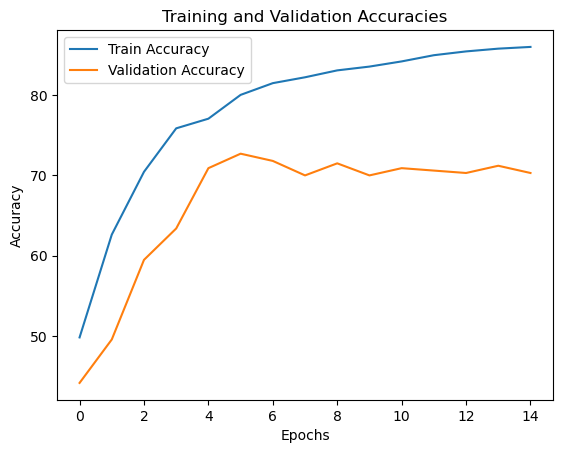

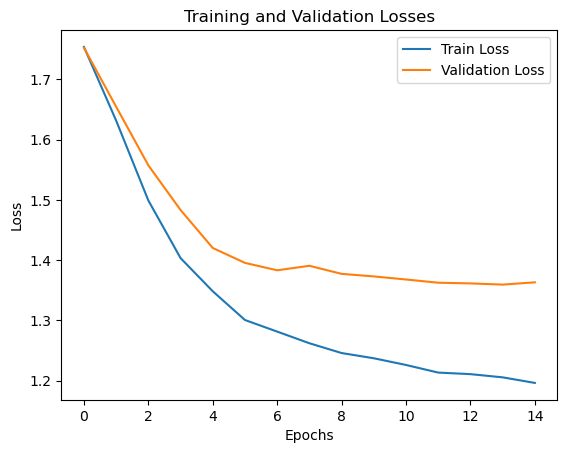

(70.67669172932331, 1.3469020128250122)

In [220]:
reset_my_seed()

arguments_mlp_citeseer = {
                 'num_epochs': 15,
                 'hidden_size': 32,
                 'n_layers': 2,
                 'lr': 0.001,
                 'batch_size':128,
                 'change_dataset': change_dataset_mlp,
                 'dropout_p': 0.5
                }
run_test_(MLP, dataset_citeseer, arguments=arguments_mlp_citeseer)

#### MLP CoraFull

In [214]:
for n_l in [1, 2, 3, 4]:
    for h_s in [32, 64, 128, 256]:
        for d_p in [0.2, 0.5, 0.8]:
            arguments_mlp_citeseer = {
                            'num_epochs': 10,
                            'hidden_size': h_s,
                            'n_layers': n_l,
                            'lr': 0.001,
                            'batch_size':128,
                            'change_dataset': change_dataset_mlp,
                            'dropout_p': d_p
                            }
            acc, loss = run_multitest_(MLP, dataset_corafull, n_tests=2, arguments=arguments_mlp_citeseer, p=False)
            print(f'{n_l} Layers, {h_s:3d} Neuron per layer, dropout_p of {d_p}: {acc:.2f}%')

1 Layers,  32 Neuron per layer, dropout_p of 0.2: 48.19%
1 Layers,  32 Neuron per layer, dropout_p of 0.5: 49.17%
1 Layers,  32 Neuron per layer, dropout_p of 0.8: 47.76%
1 Layers,  64 Neuron per layer, dropout_p of 0.2: 48.88%
1 Layers,  64 Neuron per layer, dropout_p of 0.5: 47.39%
1 Layers,  64 Neuron per layer, dropout_p of 0.8: 47.99%
1 Layers, 128 Neuron per layer, dropout_p of 0.2: 45.74%
1 Layers, 128 Neuron per layer, dropout_p of 0.5: 49.12%
1 Layers, 128 Neuron per layer, dropout_p of 0.8: 49.09%
1 Layers, 256 Neuron per layer, dropout_p of 0.2: 49.20%
1 Layers, 256 Neuron per layer, dropout_p of 0.5: 48.19%
1 Layers, 256 Neuron per layer, dropout_p of 0.8: 49.32%
2 Layers,  32 Neuron per layer, dropout_p of 0.2: 17.28%
2 Layers,  32 Neuron per layer, dropout_p of 0.5: 15.24%
2 Layers,  32 Neuron per layer, dropout_p of 0.8: 15.62%
2 Layers,  64 Neuron per layer, dropout_p of 0.2: 5.32%
2 Layers,  64 Neuron per layer, dropout_p of 0.5: 13.17%
2 Layers,  64 Neuron per layer, 

Epoch  1/15, Loss: 4.21, Train Accuracy: 28.99%, Validation Accuracy: 16.42%
Epoch  2/15, Loss: 4.03, Train Accuracy: 53.77%, Validation Accuracy: 30.47%
Epoch  3/15, Loss: 3.86, Train Accuracy: 61.81%, Validation Accuracy: 34.97%
Epoch  4/15, Loss: 3.77, Train Accuracy: 70.34%, Validation Accuracy: 41.23%
Epoch  5/15, Loss: 3.69, Train Accuracy: 74.87%, Validation Accuracy: 44.01%
Epoch  6/15, Loss: 3.63, Train Accuracy: 77.29%, Validation Accuracy: 44.62%
Epoch  7/15, Loss: 3.59, Train Accuracy: 80.16%, Validation Accuracy: 48.46%
Epoch  8/15, Loss: 3.55, Train Accuracy: 81.87%, Validation Accuracy: 47.40%
Epoch  9/15, Loss: 3.53, Train Accuracy: 83.10%, Validation Accuracy: 47.15%
Epoch 10/15, Loss: 3.51, Train Accuracy: 84.83%, Validation Accuracy: 49.32%
Epoch 11/15, Loss: 3.49, Train Accuracy: 85.56%, Validation Accuracy: 49.42%
Epoch 12/15, Loss: 3.48, Train Accuracy: 86.45%, Validation Accuracy: 49.37%
Epoch 13/15, Loss: 3.47, Train Accuracy: 87.15%, Validation Accuracy: 50.83%

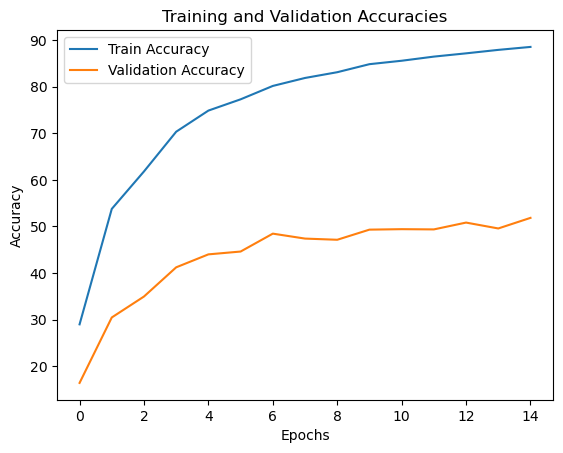

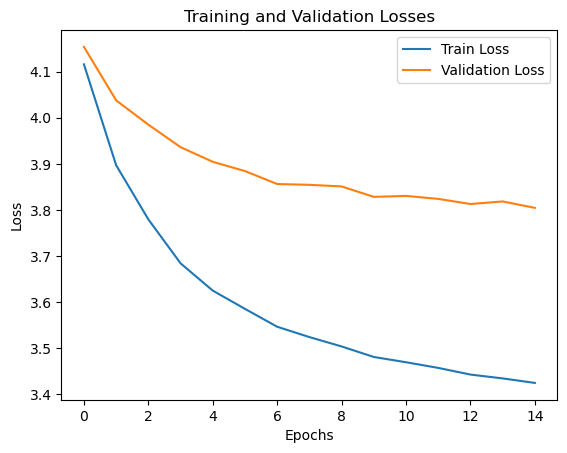

(49.962111644354636, 3.81379109813321)

In [221]:
arguments_mlp = {
                 'num_epochs': 15,
                 'hidden_size': 256,
                 'n_layers': 1,
                 'lr': 0.001,
                 'batch_size':128,
                 'change_dataset': change_dataset_mlp,
                 'dropout_p': 0.8
                }
run_test_(MLP, dataset_corafull, arguments=arguments_mlp)

### C) GCN

#### Network GCN

In [222]:
class GCN(torch.nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.5,
                weight_decay=5e-4
            ):
        super(GCN, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers

        if self.n_layers == 1:
            self.conv_out = GCNConv(input_dim, output_dim)
        else:
            self.conv_in = GCNConv(input_dim, hidden_dim)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(self.n_layers - 2)])
            self.conv_out = GCNConv(hidden_dim, output_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {self.device}")
        self.to(self.device)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)
            
            if self.n_layers > 2:
                for conv in self.conv_hiddens:
                    x = conv(x, edge_index)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)

        x = self.conv_out(x, edge_index)

        return F.log_softmax(x, dim=1)
    
    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output = self(dataset.to(self.device))
        loss = F.nll_loss(output[val_mask], dataset.y[val_mask])
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss.item()

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            output = self(dataset.to(self.device))
            loss = F.nll_loss(output[train_mask], dataset.y[train_mask])
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:3d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses



#### GCN CiteSeer

In [231]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gcn_citeseer = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.009,
                'dropout_p': 0.8,
                'weight_decay': 1e-3
            }
        acc, loss = run_multitest_(GCN, dataset_citeseer, n_tests=10, arguments=arguments_gcn_citeseer, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 75.77%
n_layers of 1, hidden_dim of  32: 75.74%
n_layers of 1, hidden_dim of  64: 75.73%
n_layers of 1, hidden_dim of 128: 75.71%
n_layers of 1, hidden_dim of 256: 75.76%
n_layers of 2, hidden_dim of  16: 74.68%
n_layers of 2, hidden_dim of  32: 74.24%
n_layers of 2, hidden_dim of  64: 73.79%
n_layers of 2, hidden_dim of 128: 73.64%
n_layers of 2, hidden_dim of 256: 73.56%
n_layers of 3, hidden_dim of  16: 73.59%
n_layers of 3, hidden_dim of  32: 73.68%
n_layers of 3, hidden_dim of  64: 73.14%
n_layers of 3, hidden_dim of 128: 72.36%
n_layers of 3, hidden_dim of 256: 72.17%



	On Train set:
	Final Accuracy: 92.87%, Final Loss: 0.3144

	On Validation set
	Final Accuracy: 71.47%, Final Loss: 0.7806

	On Test set
	Final Accuracy: 75.79%, Final Loss: 0.7169


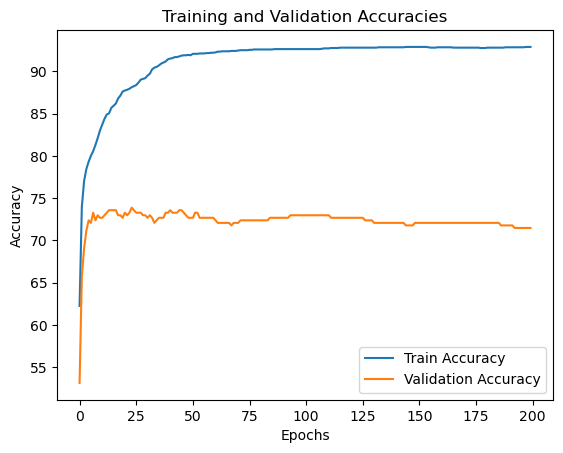

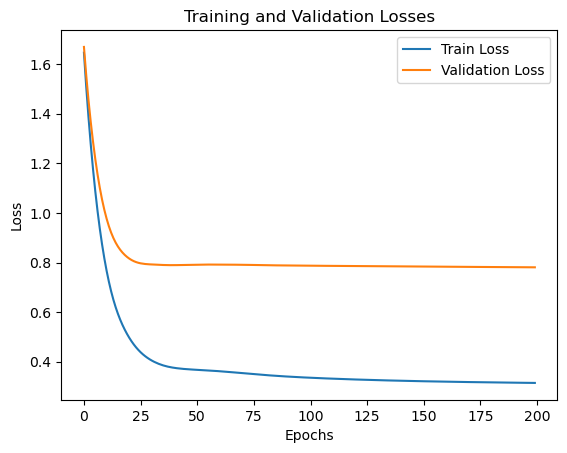

(75.78947368421053, 0.7168785929679871)

In [237]:
reset_my_seed()

arguments_gcn_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 256,
        'n_layers': 1,
        'lr': 0.009,
        'dropout_p': 0.8,
        'weight_decay': 1e-3
    }
run_test_(GCN, dataset_citeseer, arguments=arguments_gcn_citeseer, p=False)

#### GCN CoraFull

In [238]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gcn_corafull = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.01,
                'dropout_p': 0.8,
                'weight_decay': 5e-3
            }
        acc, loss = run_multitest_(GCN, dataset_corafull, n_tests=10, arguments=arguments_gcn_corafull, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 57.78%
n_layers of 1, hidden_dim of  32: 57.78%
n_layers of 1, hidden_dim of  64: 57.78%
n_layers of 1, hidden_dim of 128: 57.78%
n_layers of 1, hidden_dim of 256: 57.79%
n_layers of 2, hidden_dim of  16: 52.49%
n_layers of 2, hidden_dim of  32: 57.37%
n_layers of 2, hidden_dim of  64: 60.39%
n_layers of 2, hidden_dim of 128: 61.74%
n_layers of 2, hidden_dim of 256: 62.51%
n_layers of 3, hidden_dim of  16: 44.12%
n_layers of 3, hidden_dim of  32: 54.70%
n_layers of 3, hidden_dim of  64: 60.23%
n_layers of 3, hidden_dim of 128: 62.37%
n_layers of 3, hidden_dim of 256: 63.35%



	On Train set:
	Final Accuracy: 68.31%, Final Loss: 1.2308

	On Validation set
	Final Accuracy: 64.07%, Final Loss: 1.3966

	On Test set
	Final Accuracy: 63.37%, Final Loss: 1.3812


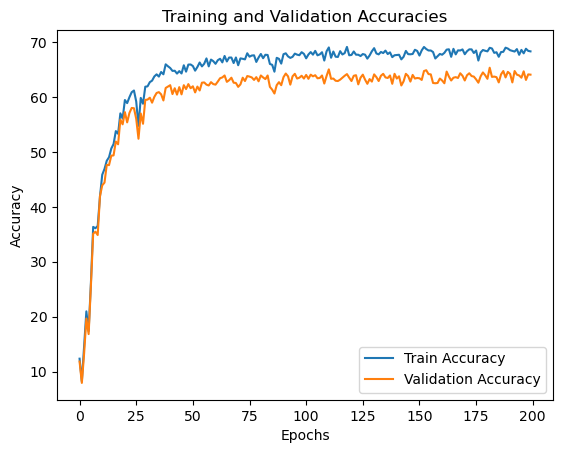

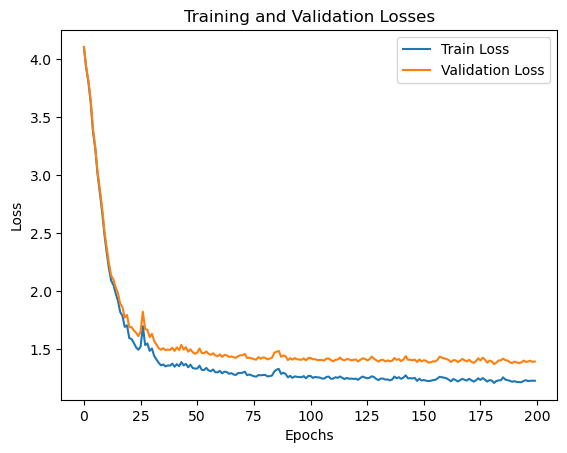

(63.374589542813844, 1.3811912536621094)

In [242]:
reset_my_seed()

arguments_gcn_corafull = {
                 'num_epochs': 200,
                 'hidden_dim': 256,
                 'n_layers': 3,
                 'lr': 0.01,
                 'dropout_p': 0.8,
                 'weight_decay': 5e-3
                }
run_test_(GCN, dataset_corafull, arguments=arguments_gcn_corafull, p=False)

### D) GAT

#### Network GAT

In [243]:
class GAT(torch.nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.5,
                n_heads=3,
                weight_decay=5e-4
            ):
        super(GAT, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers

        if self.n_layers == 1:
            self.conv_out = GATConv(input_dim, output_dim, heads=n_heads)
        else:
            self.conv_in = GATConv(input_dim, hidden_dim, heads=n_heads)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GATConv(hidden_dim * n_heads, hidden_dim, heads=n_heads) for _ in range(self.n_layers - 2)])
            self.conv_out = GATConv(hidden_dim * n_heads, output_dim, heads=n_heads)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {self.device}")
        self.to(self.device)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)
            
            if self.n_layers > 2:
                for conv in self.conv_hiddens:
                    x = conv(x, edge_index)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)

        x = self.conv_out(x, edge_index)

        return F.log_softmax(x, dim=1)
    
    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output = self(dataset.to(self.device))
        loss = F.nll_loss(output[val_mask], dataset.y[val_mask])
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss.item()

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            output = self(dataset.to(self.device))
            loss = F.nll_loss(output[train_mask], dataset.y[train_mask])
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:3d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses

#### GAT CiteSeer

In [244]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gat_citeseer = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.005,
                'dropout_p': 0.8,
                'n_heads': 1,
                'weight_decay': 5e-4
            }
        acc, loss = run_multitest_(GAT, dataset_citeseer, n_tests=10, arguments=arguments_gat_citeseer, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 71.50%
n_layers of 1, hidden_dim of  32: 72.03%
n_layers of 1, hidden_dim of  64: 72.15%
n_layers of 1, hidden_dim of 128: 72.12%
n_layers of 1, hidden_dim of 256: 72.32%
n_layers of 2, hidden_dim of  16: 74.68%
n_layers of 2, hidden_dim of  32: 74.72%
n_layers of 2, hidden_dim of  64: 74.45%
n_layers of 2, hidden_dim of 128: 73.62%
n_layers of 2, hidden_dim of 256: 73.46%
n_layers of 3, hidden_dim of  16: 73.47%
n_layers of 3, hidden_dim of  32: 74.39%
n_layers of 3, hidden_dim of  64: 73.68%
n_layers of 3, hidden_dim of 128: 72.95%
n_layers of 3, hidden_dim of 256: 72.33%


In [246]:
reset_my_seed()

for n_h in [2, 3]:
    arguments_gat_citeseer = {
            'num_epochs': 200,
            'hidden_dim': 32,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': n_h,
            'weight_decay': 5e-4
        }
    acc, loss = run_multitest_(GAT, dataset_citeseer, n_tests=10, arguments=arguments_gat_citeseer, p=False)
    print(f'n_heads of {n_h}: {acc:.2f}%')

n_heads of 2: 74.63%
n_heads of 3: 74.20%



	On Train set:
	Final Accuracy: 95.02%, Final Loss: 0.1413

	On Validation set
	Final Accuracy: 72.37%, Final Loss: 1.1199

	On Test set
	Final Accuracy: 73.83%, Final Loss: 1.0836


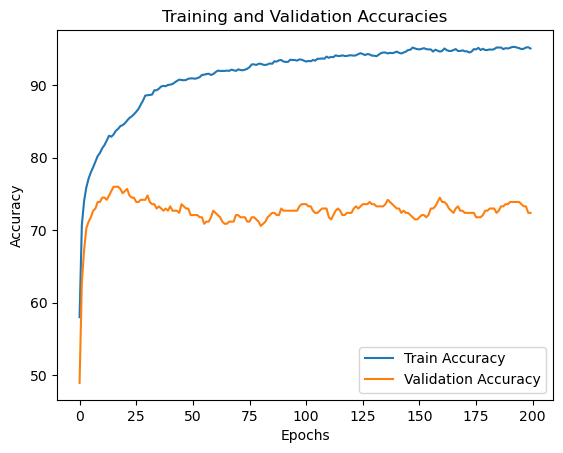

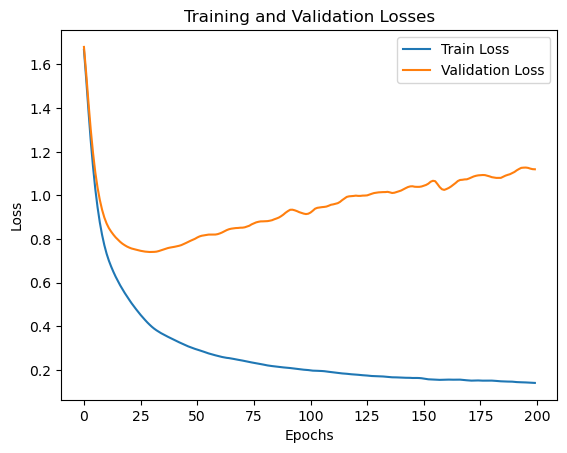

(73.8345864661654, 1.0836148262023926)

In [250]:
reset_my_seed()

arguments_gat_citeseer = {
            'num_epochs': 200,
            'hidden_dim': 32,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': 1,
            'weight_decay': 5e-4
        }
run_test_(GAT, dataset_citeseer, arguments=arguments_gat_citeseer, p=False)

#### GAT CoraFull

In [251]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gat_corafull = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.005,
                'dropout_p': 0.8,
                'n_heads': 1,
                'weight_decay': 5e-4
            }
        acc, loss = run_multitest_(GAT, dataset_corafull, n_tests=10, arguments=arguments_gat_corafull, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 60.62%
n_layers of 1, hidden_dim of  32: 60.88%
n_layers of 1, hidden_dim of  64: 60.67%
n_layers of 1, hidden_dim of 128: 60.59%
n_layers of 1, hidden_dim of 256: 60.63%
n_layers of 2, hidden_dim of  16: 61.69%
n_layers of 2, hidden_dim of  32: 66.84%
n_layers of 2, hidden_dim of  64: 68.49%
n_layers of 2, hidden_dim of 128: 68.75%
n_layers of 2, hidden_dim of 256: 68.61%
n_layers of 3, hidden_dim of  16: 45.31%
n_layers of 3, hidden_dim of  32: 60.65%
n_layers of 3, hidden_dim of  64: 67.24%
n_layers of 3, hidden_dim of 128: 68.54%
n_layers of 3, hidden_dim of 256: 68.09%


In [252]:
reset_my_seed()

for n_h in [2, 3]:
    arguments_gat_corafull = {
            'num_epochs': 200,
            'hidden_dim': 128,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': n_h,
            'weight_decay': 5e-4
        }
    acc, loss = run_multitest_(GAT, dataset_corafull, n_tests=10, arguments=arguments_gat_corafull, p=False)
    print(f'n_heads of {n_h}: {acc:.2f}%')

n_heads of 2: 69.35%
n_heads of 3: 69.32%



	On Train set:
	Final Accuracy: 93.27%, Final Loss: 0.2476

	On Validation set
	Final Accuracy: 69.78%, Final Loss: 1.1483

	On Test set
	Final Accuracy: 69.34%, Final Loss: 1.1846


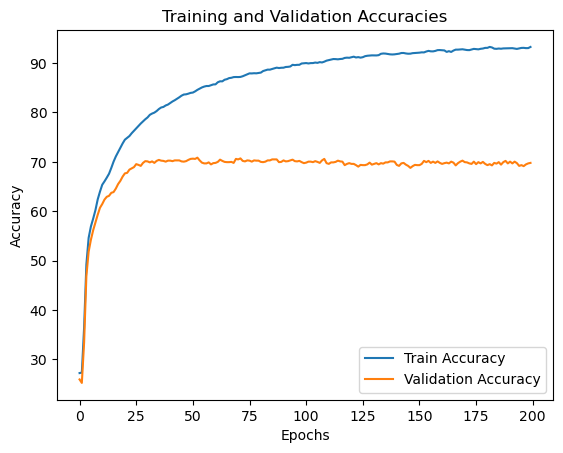

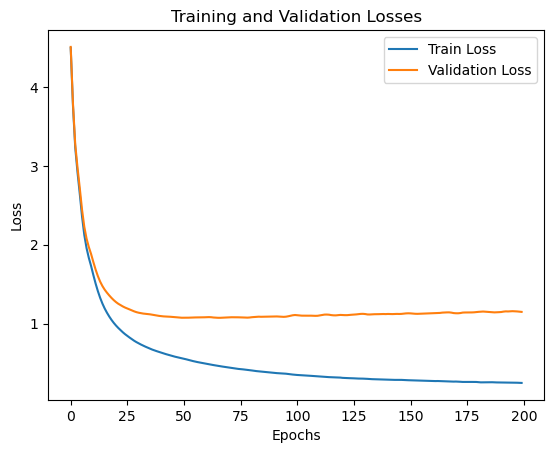

(69.33569083101794, 1.1845791339874268)

In [254]:
reset_my_seed()

arguments_gat_corafull = {
                 'num_epochs': 200,
                 'hidden_dim': 128,
                 'n_layers': 2,
                 'lr': 0.005,
                 'dropout_p': 0.8,
                 'n_heads': 2,
                 'weight_decay': 5e-4
                }
run_test_(GAT, dataset_corafull, arguments=arguments_gat_corafull, p=False)

### E) GATv2

#### Network GATv2

In [255]:
class GATv2(nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.5,
                n_heads=3,
                weight_decay=5e-4
            ):
        super(GATv2, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers

        if self.n_layers == 1:
            self.conv_out = GATv2Conv(input_dim, output_dim, heads=n_heads)
        else:
            self.conv_in = GATv2Conv(input_dim, hidden_dim, heads=n_heads)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GATv2Conv(hidden_dim * n_heads, hidden_dim, heads=n_heads) for _ in range(self.n_layers - 2)])
            self.conv_out = GATv2Conv(hidden_dim * n_heads, output_dim, heads=n_heads)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)
            
            if self.n_layers > 2:
                for conv in self.conv_hiddens:
                    x = conv(x, edge_index)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)

        x = self.conv_out(x, edge_index)

        return F.log_softmax(x, dim=1)

    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output = self(dataset.to(self.device))
        loss = F.nll_loss(output[val_mask], dataset.y[val_mask])
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss.item()

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            output = self(dataset.to(self.device))
            loss = F.nll_loss(output[train_mask], dataset.y[train_mask])
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:3d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses


#### GATv2 CiteSeer

In [256]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gatv2_citeseer = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.005,
                'dropout_p': 0.8,
                'n_heads': 1,
                'weight_decay': 5e-4
            }
        acc, loss = run_multitest_(GATv2, dataset_citeseer, n_tests=10, arguments=arguments_gatv2_citeseer, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 71.37%
n_layers of 1, hidden_dim of  32: 71.05%
n_layers of 1, hidden_dim of  64: 71.37%
n_layers of 1, hidden_dim of 128: 70.98%
n_layers of 1, hidden_dim of 256: 70.96%
n_layers of 2, hidden_dim of  16: 74.27%
n_layers of 2, hidden_dim of  32: 74.05%
n_layers of 2, hidden_dim of  64: 73.65%
n_layers of 2, hidden_dim of 128: 72.93%
n_layers of 2, hidden_dim of 256: 73.04%
n_layers of 3, hidden_dim of  16: 73.02%
n_layers of 3, hidden_dim of  32: 73.64%
n_layers of 3, hidden_dim of  64: 73.22%
n_layers of 3, hidden_dim of 128: 71.82%
n_layers of 3, hidden_dim of 256: 72.39%


In [257]:
reset_my_seed()

for n_h in [2, 3]:
    arguments_gatv2_citeseer = {
            'num_epochs': 200,
            'hidden_dim': 16,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': n_h,
            'weight_decay': 5e-4
        }
    acc, loss = run_multitest_(GAT, dataset_citeseer, n_tests=10, arguments=arguments_gatv2_citeseer, p=False)
    print(f'n_heads of {n_h}: {acc:.2f}%')

n_heads of 2: 74.50%
n_heads of 3: 74.41%



	On Train set:
	Final Accuracy: 94.29%, Final Loss: 0.1496

	On Validation set
	Final Accuracy: 73.57%, Final Loss: 1.0057

	On Test set
	Final Accuracy: 74.59%, Final Loss: 1.0069


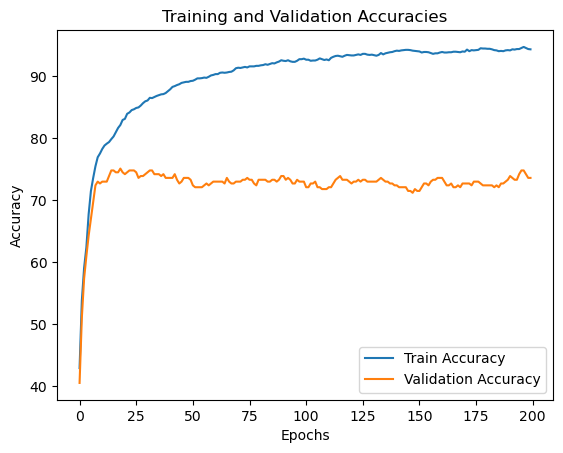

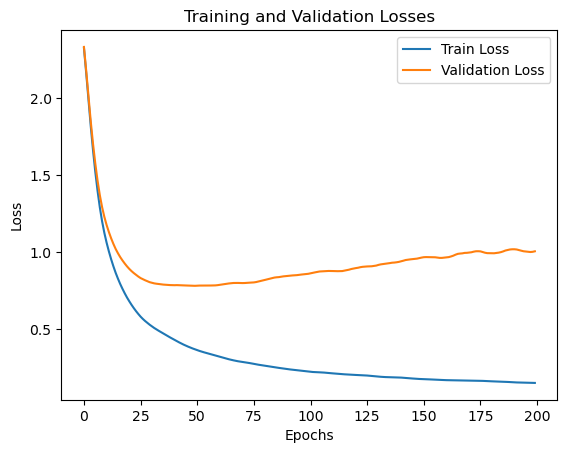

(74.58646616541354, 1.0068624019622803)

In [258]:
reset_my_seed()

arguments_gatv2_citeseer = {
            'num_epochs': 200,
            'hidden_dim': 16,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': 2,
            'weight_decay': 5e-4
        }
run_test_(GAT, dataset_citeseer, arguments=arguments_gatv2_citeseer, p=False)

#### GATv2 CoraFull

In [260]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_gatv2_corafull = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.005,
                'dropout_p': 0.8,
                'n_heads': 1,
                'weight_decay': 5e-4
            }
        acc, loss = run_multitest_(GATv2, dataset_corafull, n_tests=10, arguments=arguments_gatv2_corafull, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 62.16%
n_layers of 1, hidden_dim of  32: 62.19%
n_layers of 1, hidden_dim of  64: 62.13%
n_layers of 1, hidden_dim of 128: 62.47%
n_layers of 1, hidden_dim of 256: 62.04%
n_layers of 2, hidden_dim of  16: 62.88%
n_layers of 2, hidden_dim of  32: 67.69%
n_layers of 2, hidden_dim of  64: 68.98%
n_layers of 2, hidden_dim of 128: 68.88%
n_layers of 2, hidden_dim of 256: 68.26%
n_layers of 3, hidden_dim of  16: 39.72%
n_layers of 3, hidden_dim of  32: 59.63%
n_layers of 3, hidden_dim of  64: 67.28%
n_layers of 3, hidden_dim of 128: 68.63%
n_layers of 3, hidden_dim of 256: 68.14%


In [261]:
reset_my_seed()

for n_h in [2, 3]:
    arguments_gatv2_corafull = {
            'num_epochs': 200,
            'hidden_dim': 64,
            'n_layers': 2,
            'lr': 0.005,
            'dropout_p': 0.8,
            'n_heads': n_h,
            'weight_decay': 5e-4
        }
    acc, loss = run_multitest_(GATv2, dataset_corafull, n_tests=10, arguments=arguments_gatv2_corafull, p=False)
    print(f'n_heads of {n_h}: {acc:.2f}%')

n_heads of 2: 69.78%
n_heads of 3: 69.81%



	On Train set:
	Final Accuracy: 92.47%, Final Loss: 0.2772

	On Validation set
	Final Accuracy: 69.98%, Final Loss: 1.1197

	On Test set
	Final Accuracy: 69.74%, Final Loss: 1.1513


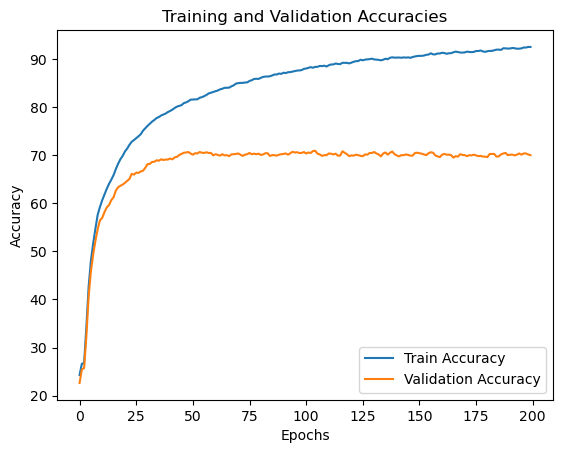

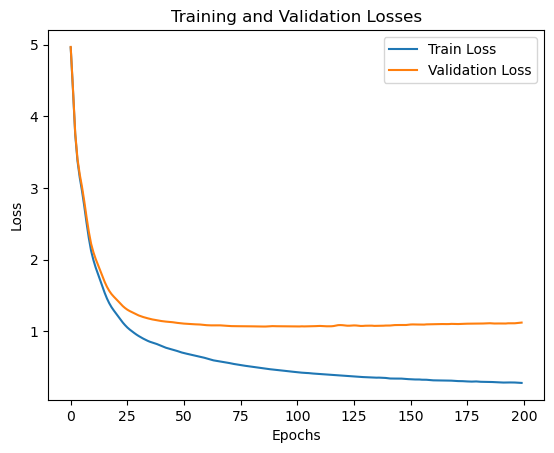

(69.73983329123516, 1.1512573957443237)

In [262]:
reset_my_seed()

arguments_gatv2_corafull = {
                 'num_epochs': 200,
                 'hidden_dim': 64,
                 'n_layers': 2,
                 'lr': 0.005,
                 'dropout_p': 0.8,
                 'n_heads': 3,
                 'weight_decay': 5e-4
                }
run_test_(GATv2, dataset_corafull, arguments=arguments_gatv2_corafull, p=False)

## 3rd Question

### B) Implementation (DropEdge + GCN = DropEdgeGCN)

In [305]:
class DropEdgeGCN(torch.nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.8,
                dropedge_p=0.8,
                weight_decay=5e-4,
                layer_wise=False
            ):
        super(DropEdgeGCN, self).__init__()

        self.dropout_p = dropout_p
        self.dropedge_p = dropedge_p
        self.n_layers = n_layers
        self.layer_wise = layer_wise

        if self.n_layers == 1:
            self.conv_out = GCNConv(input_dim, output_dim)
        else:
            self.conv_in = GCNConv(input_dim, hidden_dim)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(self.n_layers - 2)])
            self.conv_out = GCNConv(hidden_dim, output_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {self.device}")
        self.to(self.device)

    def DropEdge(self, edge_index_A):
        if self.training:
            edge_mask = torch.rand(edge_index_A.size(1)) > self.dropedge_p
            edge_index_A_drop = edge_index_A[:, edge_mask]
            return edge_index_A_drop

        return edge_index_A

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_index_dropedge = self.DropEdge(edge_index)

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index_dropedge)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)

            if self.layer_wise:
                edge_index_dropedge = self.DropEdge(edge_index)
            
            if self.n_layers > 2:
                for conv in self.conv_hiddens:
                    x = conv(x, edge_index_dropedge)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)

                    if self.layer_wise:
                        edge_index_dropedge = self.DropEdge(edge_index)

        x = self.conv_out(x, edge_index_dropedge)

        return F.log_softmax(x, dim=1)
    
    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output = self(dataset.to(self.device))
        loss = F.nll_loss(output[val_mask], dataset.y[val_mask])
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss.item()

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            output = self(dataset.to(self.device))
            loss = F.nll_loss(output[train_mask], dataset.y[train_mask])
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:2d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses


### C) Train & Test

#### DropEdgeGCN CiteSeer

In [266]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_dropedgegcn_citeseer = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.009,
                'dropout_p': 0.8,
                'weight_decay': 1e-3,
                'dropedge_p': 0.5,
                'layer_wise':False
            }
        acc, loss = run_multitest_(DropEdgeGCN, dataset_citeseer, n_tests=10, arguments=arguments_dropedgegcn_citeseer, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 76.45%
n_layers of 1, hidden_dim of  32: 76.42%
n_layers of 1, hidden_dim of  64: 76.32%
n_layers of 1, hidden_dim of 128: 76.45%
n_layers of 1, hidden_dim of 256: 76.44%
n_layers of 2, hidden_dim of  16: 75.80%
n_layers of 2, hidden_dim of  32: 75.73%
n_layers of 2, hidden_dim of  64: 75.41%
n_layers of 2, hidden_dim of 128: 75.13%
n_layers of 2, hidden_dim of 256: 74.83%
n_layers of 3, hidden_dim of  16: 72.57%
n_layers of 3, hidden_dim of  32: 74.93%
n_layers of 3, hidden_dim of  64: 75.38%
n_layers of 3, hidden_dim of 128: 75.31%
n_layers of 3, hidden_dim of 256: 74.74%


In [267]:
reset_my_seed()

for d_p in [0.2, 0.8]:
    arguments_dropedgegcn_citeseer = {
            'num_epochs': 200,
            'hidden_dim': 16,
            'n_layers': 1,
            'lr': 0.009,
            'dropout_p': 0.8,
            'weight_decay': 1e-3,
            'dropedge_p': d_p,
            'layer_wise':False
        }
    acc, loss = run_multitest_(DropEdgeGCN, dataset_citeseer, n_tests=10, arguments=arguments_dropedgegcn_citeseer, p=False)
    print(f'dropedge_p of {d_p}: {acc:.2f}%')

dropedge_p of 0.2: 76.24%
dropedge_p of 0.8: 76.89%



	On Train set:
	Final Accuracy: 89.05%, Final Loss: 0.3972

	On Validation set
	Final Accuracy: 73.57%, Final Loss: 0.7694

	On Test set
	Final Accuracy: 76.69%, Final Loss: 0.7193


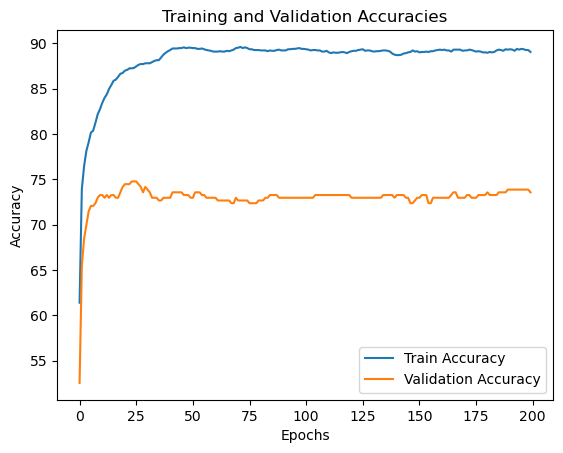

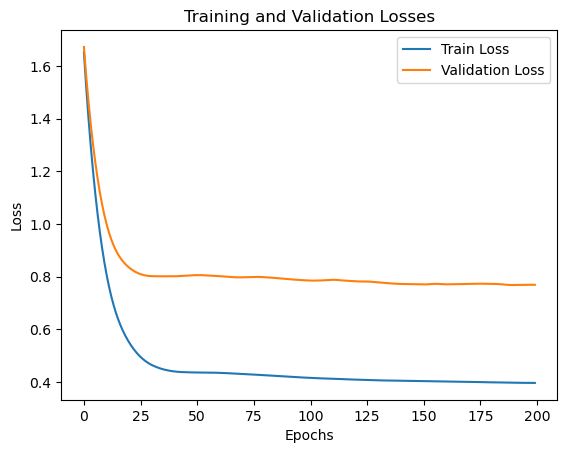

(76.69172932330827, 0.7193259596824646)

In [269]:
reset_my_seed()

arguments_dropedgegcn_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 16,
        'n_layers': 1,
        'lr': 0.009,
        'dropout_p': 0.8,
        'weight_decay': 1e-3,
        'dropedge_p': 0.8,
        'layer_wise':False
    }
run_test_(DropEdgeGCN, dataset_citeseer, arguments=arguments_dropedgegcn_citeseer, p=False)

#### DropEdgeGCN CoraFull

In [270]:
reset_my_seed()

for n_l in [1, 2, 3]:
    for h_d in [16, 32, 64, 128, 256]:
        arguments_dropedgegcn_corafull = {
                'num_epochs': 200,
                'hidden_dim': h_d,
                'n_layers': n_l,
                'lr': 0.009,
                'dropout_p': 0.8,
                'weight_decay': 1e-3,
                'dropedge_p': 0.5,
                'layer_wise':False
            }
        acc, loss = run_multitest_(DropEdgeGCN, dataset_corafull, n_tests=10, arguments=arguments_dropedgegcn_corafull, p=False)
        print(f'n_layers of {n_l}, hidden_dim of {h_d:3d}: {acc:.2f}%')

n_layers of 1, hidden_dim of  16: 68.52%
n_layers of 1, hidden_dim of  32: 68.46%
n_layers of 1, hidden_dim of  64: 68.50%
n_layers of 1, hidden_dim of 128: 68.47%
n_layers of 1, hidden_dim of 256: 68.39%
n_layers of 2, hidden_dim of  16: 57.49%
n_layers of 2, hidden_dim of  32: 64.70%
n_layers of 2, hidden_dim of  64: 68.79%
n_layers of 2, hidden_dim of 128: 70.29%
n_layers of 2, hidden_dim of 256: 70.84%
n_layers of 3, hidden_dim of  16: 37.15%
n_layers of 3, hidden_dim of  32: 52.99%
n_layers of 3, hidden_dim of  64: 61.25%
n_layers of 3, hidden_dim of 128: 66.56%
n_layers of 3, hidden_dim of 256: 68.81%


In [271]:
reset_my_seed()

for d_p in [0.2, 0.8]:
    arguments_dropedgegcn_corafull = {
            'num_epochs': 200,
            'hidden_dim': 256,
            'n_layers': 2,
            'lr': 0.009,
            'dropout_p': 0.8,
            'weight_decay': 1e-3,
            'dropedge_p': d_p,
            'layer_wise':False
        }
    acc, loss = run_multitest_(DropEdgeGCN, dataset_corafull, n_tests=10, arguments=arguments_dropedgegcn_corafull, p=False)
    print(f'dropedge_p of {d_p}: {acc:.2f}%')

dropedge_p of 0.2: 71.27%
dropedge_p of 0.8: 70.43%



	On Train set:
	Final Accuracy: 82.40%, Final Loss: 0.6989

	On Validation set
	Final Accuracy: 71.40%, Final Loss: 1.0469

	On Test set
	Final Accuracy: 71.26%, Final Loss: 1.0598


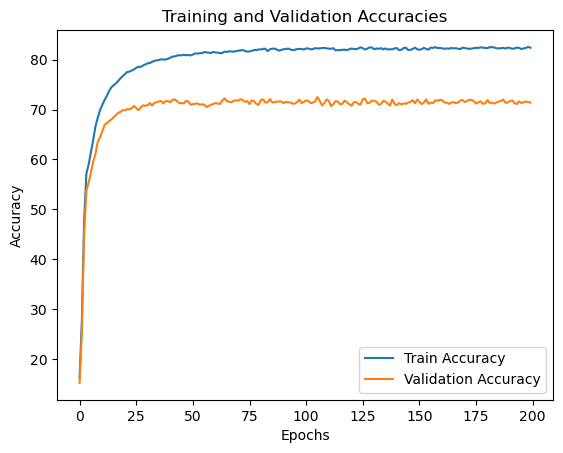

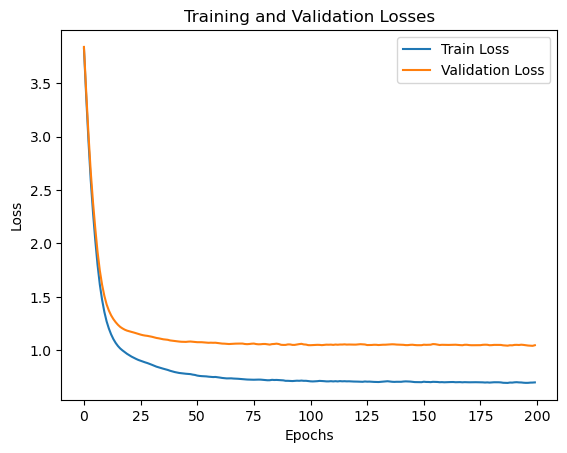

(71.25536751704976, 1.0597584247589111)

In [273]:
reset_my_seed()

arguments_dropedgegcn_corafull = {
        'num_epochs': 200,
        'hidden_dim': 256,
        'n_layers': 2,
        'lr': 0.009,
        'dropout_p': 0.8,
        'weight_decay': 1e-3,
        'dropedge_p': 0.2,
        'layer_wise':False
    }
run_test_(DropEdgeGCN, dataset_corafull, arguments=arguments_dropedgegcn_corafull, p=False)

### G) 8-layer DropEdgeGCN

#### DropEdgeGCN-8 CiteSeer


	On Train set:
	Final Accuracy: 75.05%, Final Loss: 0.7942

	On Validation set
	Final Accuracy: 66.97%, Final Loss: 1.3212

	On Test set
	Final Accuracy: 67.82%, Final Loss: 1.1434


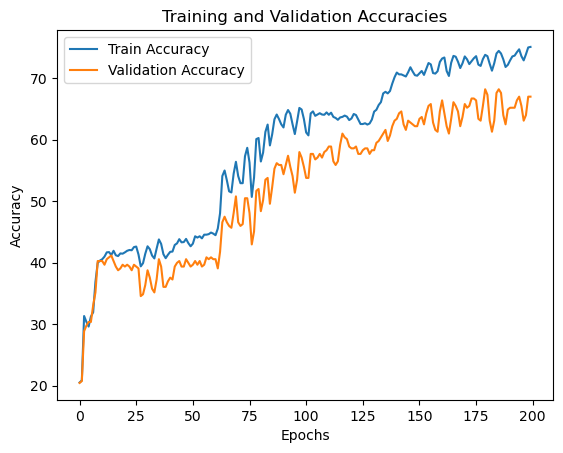

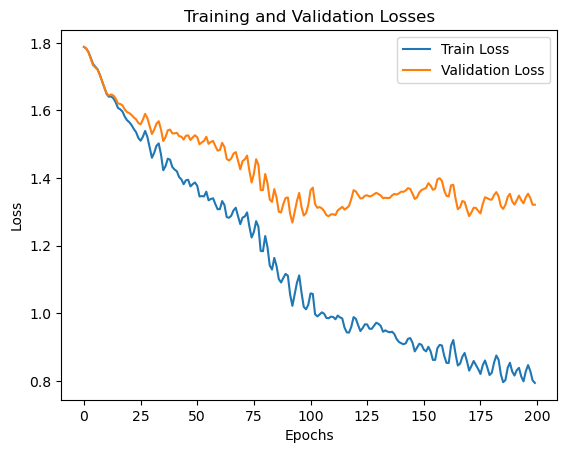

(67.81954887218045, 1.143377423286438)

In [336]:
reset_my_seed()

arguments_dropedgegcn8_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 16,
        'n_layers': 8,
        'lr': 0.01,
        'dropout_p': 0.5,
        'weight_decay': 1e-3,
        'dropedge_p': 0.5,
        'layer_wise': True
    }
run_test_(DropEdgeGCN, dataset_citeseer, arguments=arguments_dropedgegcn8_citeseer, p=False)


	On Train set:
	Final Accuracy: 49.94%, Final Loss: 1.2708

	On Validation set
	Final Accuracy: 42.94%, Final Loss: 1.4509

	On Test set
	Final Accuracy: 46.62%, Final Loss: 1.4798


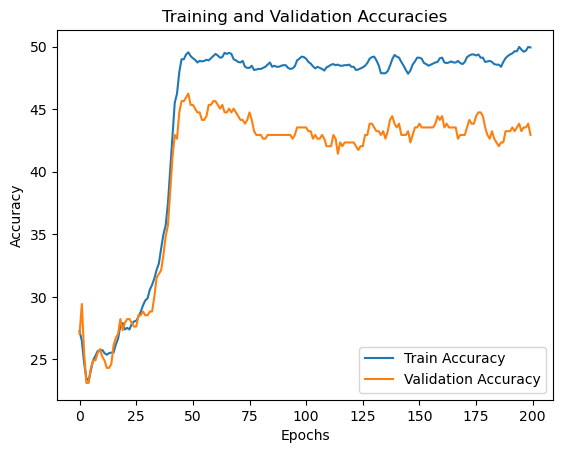

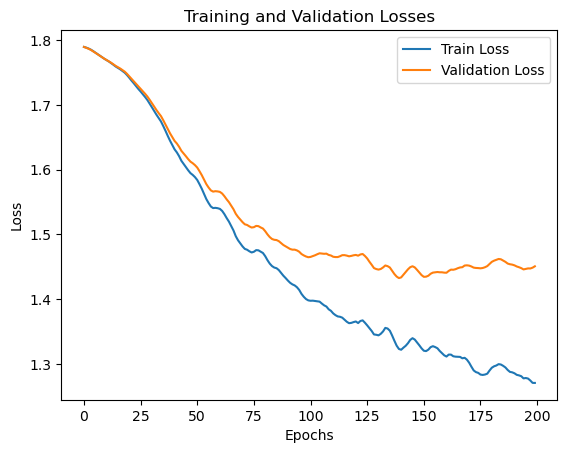

(46.616541353383454, 1.4797536134719849)

In [306]:
reset_my_seed()

arguments_dropedgegcn8_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 16,
        'n_layers': 4,
        'lr': 0.005,
        'dropout_p': 0.8,
        'weight_decay': 5e-4,
        'dropedge_p': 0.8,
        'layer_wise': True
    }
run_test_(DropEdgeGCN, dataset_citeseer, arguments=arguments_dropedgegcn8_citeseer, p=False)

### H) skip-connection

#### Network SkipConnectionGCN

In [297]:
class SkipConnectionGCN(torch.nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.5,
                weight_decay=5e-4
            ):
        super(SkipConnectionGCN, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers

        if self.n_layers == 1:
            self.conv_out = GCNConv(input_dim, output_dim)
        else:
            self.conv_in = GCNConv(input_dim, hidden_dim)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(self.n_layers - 2)])
            self.conv_out = GCNConv(hidden_dim, output_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {self.device}")
        self.to(self.device)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        layer_outputs = []

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index)
            layer_outputs.append(x)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)
            
            if self.n_layers > 2:
                for conv in self.conv_hiddens:
                    x = conv(x, edge_index)
                    layer_outputs.append(x)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)
        
        
        for layer_output in layer_outputs:
            x += layer_output
        
        x = self.conv_out(x, edge_index)

        return F.log_softmax(x, dim=1)
    
    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output = self(dataset.to(self.device))
        loss = F.nll_loss(output[val_mask], dataset.y[val_mask])
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss.item()

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            output = self(dataset.to(self.device))
            loss = F.nll_loss(output[train_mask], dataset.y[train_mask])
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

            if p:
                print(f"Epoch {epoch+1:3d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses



#### SkipConnectionGCN CiteSeer


	On Train set:
	Final Accuracy: 95.53%, Final Loss: 0.1327

	On Validation set
	Final Accuracy: 71.47%, Final Loss: 1.1772

	On Test set
	Final Accuracy: 72.78%, Final Loss: 1.0843


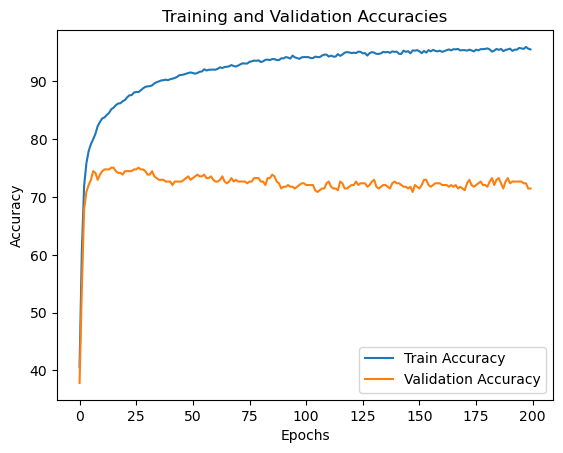

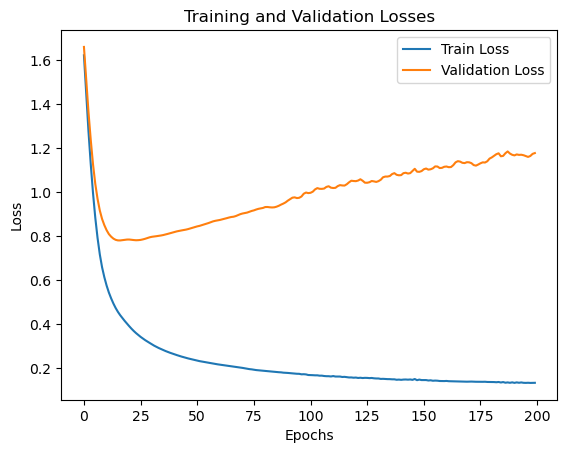

(72.78195488721805, 1.0843008756637573)

In [338]:
reset_my_seed()

arguments_skipconnectiongcn8_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 16,
        'n_layers': 8,
        'lr': 0.009,
        'dropout_p': 0.8,
        'weight_decay': 1e-3
    }
run_test_(SkipConnectionGCN, dataset_citeseer, arguments=arguments_skipconnectiongcn8_citeseer, p=False)

### I) Deeply Supervised Graph Neural Network (DSGNN)

#### Network DSGNN

In [382]:
class DSGNN(torch.nn.Module):
    def __init__(
                self,
                input_dim,
                output_dim,
                hidden_dim=16,
                n_layers=2,
                lr=0.01,
                dropout_p=0.5,
                weight_decay=5e-4,
                aux_loss_weight=0.1  # Weight for auxiliary loss
            ):
        super(DSGNN, self).__init__()

        self.dropout_p = dropout_p
        self.n_layers = n_layers
        self.aux_loss_weight = aux_loss_weight

        if self.n_layers == 1:
            self.conv_out = GCNConv(input_dim, output_dim)
        else:
            self.conv_in = GCNConv(input_dim, hidden_dim)
            if self.n_layers > 2:
                self.conv_hiddens = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(self.n_layers - 2)])
            self.conv_out = GCNConv(hidden_dim, output_dim)

            # Auxiliary classifiers
            self.aux_classifiers = nn.ModuleList([nn.Linear(hidden_dim, output_dim) for _ in range(self.n_layers - 1)])

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        aux_losses = []

        if self.n_layers > 1:
            x = self.conv_in(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout_p)
            
            if self.n_layers > 2:
                for i, conv in enumerate(self.conv_hiddens):
                    x = conv(x, edge_index)
                    x = F.relu(x)
                    x = F.dropout(x, training=self.training, p=self.dropout_p)

                    # Auxiliary classifier
                    aux_output = self.aux_classifiers[i](x)
                    aux_loss = F.nll_loss(F.log_softmax(aux_output, dim=1), data.y)
                    aux_losses.append(aux_loss * self.aux_loss_weight)

        x = self.conv_out(x, edge_index)

        main_output = F.log_softmax(x, dim=1)

        # Total loss
        total_loss = F.nll_loss(main_output, data.y)
        for aux_loss in aux_losses:
            total_loss += aux_loss

        return main_output, total_loss
    
    def evaluate_function(self, dataset, val_mask):
        self.eval()
        output, loss = self(dataset.to(self.device))
        _, pred = output.max(dim=1)
        correct = int(pred[val_mask].eq(dataset.y[val_mask]).sum().item())
        accuracy = correct / int(val_mask.sum()) * 100
        return accuracy, loss

    def train_function(self, dataset, train_mask, val_mask, num_epochs=20, p=True):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            self.train()
            self.optimizer.zero_grad()
            _, loss = self(dataset.to(self.device))
            loss.backward()
            self.optimizer.step()

            train_accuracy, train_loss = self.evaluate_function(dataset, train_mask)
            val_accuracy, val_loss = self.evaluate_function(dataset, val_mask)

            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss.item())

            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss.item())

            if p:
                print(f"Epoch {epoch+1:3d}/{num_epochs}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

        return train_accuracies, val_accuracies, train_losses, val_losses


#### DSGNN CiteSeer


	On Train set:
	Final Accuracy: 86.69%, Final Loss: 0.3441

	On Validation set
	Final Accuracy: 84.98%, Final Loss: 0.3441

	On Test set
	Final Accuracy: 85.11%, Final Loss: 0.3441


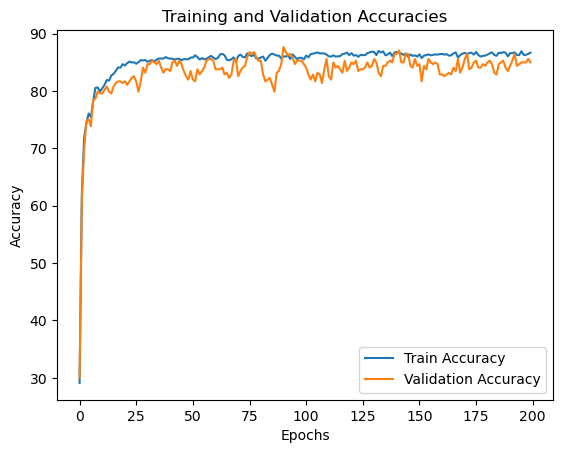

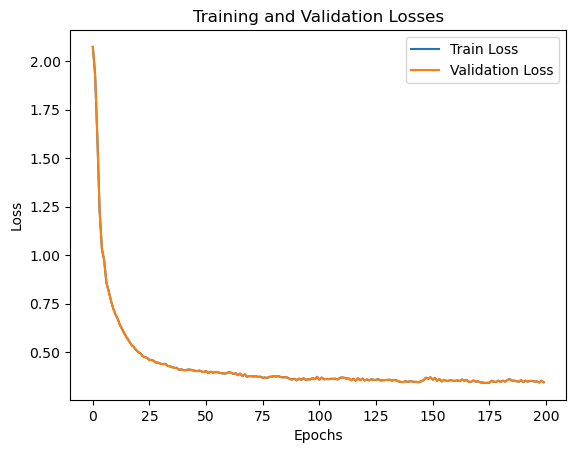

(85.11278195488721, tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>))

In [383]:
reset_my_seed()

arguments_gcn_citeseer = {
        'num_epochs': 200,
        'hidden_dim': 256,
        'n_layers': 4,
        'lr': 0.009,
        'dropout_p': 0.8,
        'weight_decay': 1e-3
    }
run_test_(DSGNN, dataset_citeseer, arguments=arguments_gcn_citeseer, p=False)